In [1]:
# ========= 1) Setup =========
# Install required libraries if needed
# !pip install medmnist torch torchvision shap matplotlib

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import shap
import numpy as np
import random
import os

import medmnist
from medmnist import INFO

c:\Users\lijv1.LINDA_HP\Documents\GitHub\SHAP-MedMNIST\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ========= 2) Dataset Info =========
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
n_classes = len(info['label'])
id2label = {int(k): v for k, v in info['label'].items()}

print(f"Dataset: {info['description']}")
print(f"Task: {info['task']}, Classes: {n_classes}")
print("Classes:", id2label)

Dataset: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Task: multi-class, Classes: 9
Classes: {0: 'adipose', 1: 'background', 2: 'debris', 3: 'lymphocytes', 4: 'mucus', 5: 'smooth muscle', 6: 'normal colon mucosa', 7: 'cancer-associated stroma', 8: 'colorectal adenocarcinoma epithelium'}


C:\Users\lijv1.LINDA_HP\AppData\Local\Temp\ipykernel_35580\3842754038.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i].set_title(f"{id2label[int(label)]}")  # ✅ cast label to int
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32549018..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44313723..0.90588236].


Train size: 89996  Test size: 7180


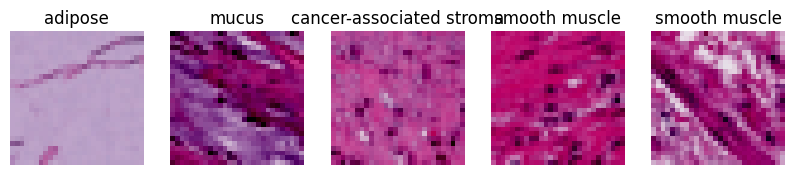

In [3]:
# ========= 3) Load dataset =========
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=transform, download=download)
test_dataset  = DataClass(split='test', transform=transform, download=download)

print("Train size:", len(train_dataset), " Test size:", len(test_dataset))

# Show 5 sample images
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img, label = train_dataset[i]
    img = img.numpy()
    axs[i].imshow(np.transpose(img, (1, 2, 0)).squeeze(), cmap="gray")
    axs[i].set_title(f"{id2label[int(label)]}")  # ✅ cast label to int
    axs[i].axis("off")
plt.show()

In [4]:
# ========= 4) Define Simple CNN Model (already provided) =========
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*14*14, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x

model = SimpleCNN(info['n_channels'], n_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model class defined and ready.")

Model class defined and ready.


In [5]:
# ========= 5) Load Pretrained Model =========
MODEL_PATH = "pathmnist_simplecnn.pth"

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print("Pretrained model loaded successfully!")

Pretrained model loaded successfully!


C:\Users\lijv1.LINDA_HP\AppData\Local\Temp\ipykernel_35580\402144953.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_idx = int(sample_label)


Predicción: normal colon mucosa (p = 70.86%)
Etiqueta real: colorectal adenocarcinoma epithelium
Top-3: [('normal colon mucosa', 0.7085862755775452), ('colorectal adenocarcinoma epithelium', 0.24647419154644012), ('debris', 0.03077833727002144)]


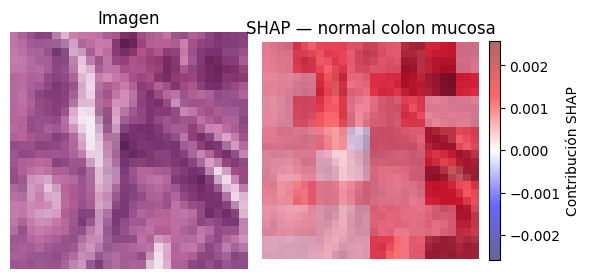

In [6]:
# ========= 6) Predictions + SHAP Explanations =========
# In this cell, you will:
#   1. Write a helper function so SHAP can call the model
#   2. Pick one test image and predict its class
#   3. Compare prediction vs. true label
#   4. Use SHAP to explain WHY the model made that prediction
#   5. Visualize the results

# --- Step 1: Helper function for SHAP ---
# TODO: Implement model_forward(x)
# HINT: x will come as a numpy array with shape (N, H, W, C).
#       Convert it to a torch tensor (N, C, H, W), run through the model,
#       return probabilities as numpy.
def model_forward(x: np.ndarray) -> np.ndarray:
    model.eval()
    with torch.no_grad():
        if isinstance(x, list):
            x = np.stack(x, axis=0)
        x = x.astype(np.float32)

        # Si viene en [0,255], escalar a [0,1]
        if x.max() > 1.0:
            x = x / 255.0

        # Asegurar dimensión batch
        if x.ndim == 3:
            x = x[None, ...]  # (1,H,W,C)

        # Alinear canales esperados vs. provistos
        if x.shape[-1] != info['n_channels']:
            if x.shape[-1] == 1 and info['n_channels'] == 3:
                x = np.repeat(x, 3, axis=-1)  # gris -> RGB
            elif x.shape[-1] == 3 and info['n_channels'] == 1:
                x = x[..., :1]                # RGB -> gris
            else:
                raise ValueError(f"Se esperaban {info['n_channels']} canales, llegó {x.shape[-1]}.")

        # HWC -> CHW y normalización (mean=0.5, std=0.5)
        x_t = torch.from_numpy(x).permute(0, 3, 1, 2)
        x_t = (x_t - 0.5) / 0.5
        x_t = x_t.to(device)

        logits = model(x_t)
        probs = F.softmax(logits, dim=1).cpu().numpy()  # <-- línea correcta
    return probs

# --- Step 2: Pick one test image ---
# TODO: Select an image from test_dataset
# HINT: take sample_img, sample_label = test_dataset[0] (or a random index)
# TODO: Predict class probabilities using the model
# TODO: Print predicted class (with probability) and true label
# (use id2label to show class names)

idx = 0  # puedes cambiar a otro índice o usar np.random.randint(len(test_dataset))
sample_img_t, sample_label = test_dataset[idx]        # sample_img_t: (C,H,W) normalizada
x_batch = sample_img_t.unsqueeze(0).to(device)        # (1,C,H,W)

model.eval()
with torch.no_grad():
    logits = model(x_batch)
    probs_pt = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()

pred_idx = int(probs_pt.argmax())
true_idx = int(sample_label)
print(f"Predicción: {id2label[pred_idx]} (p = {probs_pt[pred_idx]:.2%})")
print(f"Etiqueta real: {id2label[true_idx]}")

# (Opcional) Top-3
top3 = probs_pt.argsort()[-3:][::-1]
print("Top-3:", [(id2label[int(i)], float(probs_pt[i])) for i in top3])


# --- Step 3: Prepare image for SHAP ---
# TODO: Convert the image into numpy format (H, W, C)
# HINT: remember test_dataset gives (C, H, W), so you might need np.transpose
sample_img_np = sample_img_t.permute(1, 2, 0).cpu().numpy().astype(np.float32)  # (H,W,C) en [-1,1]
sample_img_np = (sample_img_np * 0.5) + 0.5                                     # -> [0,1]
sample_img_np = np.clip(sample_img_np, 0.0, 1.0)

# --- Step 4: Create SHAP explainer ---
# TODO: Create a masker for images
# HINT: shap.maskers.Image("blur(28,28)", img_np.shape)
# TODO: Create an Explainer with (model_forward, masker)
# TODO: Run explainer on your selected image
# Asegurar probas y clase predicha (por si no quedó en el Step 2)
probs = model_forward(sample_img_np[np.newaxis, ...])[0]
pred_idx = int(probs.argmax())

# 4.1) Masker de imagen (usar desenfoque sobre patches)
# Nota: usa el tamaño de la imagen; para PathMNIST es 28x28 (y 3 canales)
masker = shap.maskers.Image("blur(28,28)", sample_img_np.shape)

# 4.2) Explainer modelo-agnóstico
class_names = [id2label[i] for i in range(n_classes)]
explainer = shap.Explainer(model_forward, masker, output_names=class_names)

# 4.3) Ejecutar el explainer sobre la imagen seleccionada
explanation = explainer(sample_img_np[np.newaxis, ...], max_evals=1000, batch_size=50)

# --- Step 5: Visualize ---
# TODO: Plot the original image and the SHAP heatmap side by side
# HINT: use matplotlib subplots
vals = explanation.values  # esperado: (1, H, W, C, n_classes) o (1, H, W, C)
if vals.ndim == 5:
    shap_map = vals[0, :, :, :, pred_idx]   # (H, W, C) para la clase predicha
elif vals.ndim == 4:
    shap_map = vals[0]                      # (H, W, C)
else:
    raise ValueError(f"Dimensión inesperada en explanation.values: {vals.shape}")

# Agregar canales para un mapa 2D 
shap_2d = shap_map.sum(axis=2)
v = float(np.abs(shap_2d).max()) + 1e-12   
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Imagen original
axs[0].imshow(sample_img_np.squeeze(), cmap="gray" if sample_img_np.shape[2] == 1 else None)
axs[0].set_title("Imagen")
axs[0].axis("off")

# Overlay: imagen + heatmap SHAP
axs[1].imshow(sample_img_np.squeeze(), cmap="gray" if sample_img_np.shape[2] == 1 else None)
hm = axs[1].imshow(shap_2d, cmap="seismic", alpha=0.6, vmin=-v, vmax=v)
axs[1].set_title(f"SHAP — {id2label[pred_idx]}")
axs[1].axis("off")

cbar = fig.colorbar(hm, ax=axs[1], fraction=0.046, pad=0.04)
cbar.set_label("Contribución SHAP")

plt.tight_layout()
plt.show()

In [7]:
# ========= 7) Extension: Multiple Images =========
# TODO: Loop over 5 random test images
# For each:
#   - Show original image with true label
#   - Predict with the model and show predicted label + probability
#   - Plot SHAP heatmap for predicted class
# HINT: Use matplotlib with 2 rows and 5 columns

In [8]:
# ========= 8) Reflection =========
# Answer in text (Markdown or comments):
# 1. Why did the model predict this class?
# 2. Are the SHAP heatmaps focusing on meaningful regions?
# 3. What differences do you see between correct and incorrect predictions?
# 4. How could interpretability help improve this model?